In [ ]:
!pip install -U "transformers>=4.39.0"
!pip install peft bitsandbytes
!pip install -U "trl>=0.8.3"
!pip install accelerate

In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap.git

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-d8l3qti3
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-d8l3qti3
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')

In [ ]:
"""
Fine-tunes a vision–language model Llavav1.5-7B(using LlavaForConditionalGeneration)
for image captioning on the VizWiz dataset using QLoRA.
This script first runs inference on a sample from the validation set using the pretrained model,
then fine-tunes the model using the 5000 samples from training dataset, and finally runs inference again to compare results.
"""

import os
import logging
import yaml
import torch
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from trl import SFTTrainer

from transformers import (
    AutoTokenizer,
    AutoProcessor,
    TrainingArguments,
    LlavaForConditionalGeneration,
    BitsAndBytesConfig,
    DataCollatorForSeq2Seq
)
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

In [ ]:
# Configuration and Setup
# PREPROCESSED_FILE should point to the folder containing CSV files (train.csv and valid.csv)
PREPROCESSED_FILE = "/content/drive/MyDrive/EnigmaAI/dataset/preprocessed"
IMAGE_FOLDER = "/content/drive/MyDrive/EnigmaAI/dataset/images"
OUTPUT_DIR = "/content/drive/MyDrive/EnigmaAI/models/fine_tuned_model"

# Training hyperparameters
MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
EPOCHS = 10
BATCH_SIZE = 4
MAX_TARGET_LENGTH = 100
gradient_checkpointing = True


def setup_logging():
    logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

setup_logging()
logging.info("Loading feature extractor and tokenizer...")
processor = AutoProcessor.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [ ]:
# Custom Trainer
class CustomSFTTrainer(SFTTrainer):
    def __init__(self, *args, label_names=None, **kwargs):
        self.custom_label_names = label_names if label_names is not None else ["labels", "attention_mask"]
        super().__init__(*args, **kwargs)

    def _get_label_names(self, inputs):
        return self.custom_label_names

In [ ]:
# Data Collator
def custom_data_collator(features):
    # Extracting sequences from features.
    input_ids = [f["input_ids"] for f in features]
    labels = [f["labels"] for f in features]
    attention_masks = [f["attention_mask"] for f in features]

    # Using the tokenizer's pad method to pad sequences.
    padded_inputs = tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_masks},
        padding="longest",
        return_tensors="pt"
    )
    padded_labels = tokenizer.pad(
        {"input_ids": labels},
        padding="longest",
        return_tensors="pt"
    )
    padded_labels["labels"] = padded_labels["input_ids"]
    # Stacking image pixel values.
    pixel_values = torch.stack([
        f["pixel_values"] if isinstance(f["pixel_values"], torch.Tensor)
        else torch.tensor(f["pixel_values"]) for f in features
    ])
    return {
        "input_ids": padded_inputs["input_ids"],
        "attention_mask": padded_inputs["attention_mask"],
        "labels": padded_labels["labels"],
        "pixel_values": pixel_values
    }

In [ ]:
# Dataset Creation and Preprocessing

def create_dataset_from_csv(csv_path: str, image_folder: str, type: str):
    df = pd.read_csv(csv_path)
    samples = []
    for _, row in df.iterrows():
        # Build full image path from the file_name column
        file_name = row.get("file_name")
        image_path = os.path.join(image_folder, type, file_name)
        caption = row["caption"]
        samples.append({"image_path": image_path, "text": caption})
    return Dataset.from_dict({
        "image_path": [s["image_path"] for s in samples],
        "text": [s["text"] for s in samples]
    })

In [ ]:
# Preprocessing
def preprocess_image_cap(sample, processor, tokenizer, max_target_length=64, max_source_length=128):
    """
    Loads the image and creates a concatenated sequence of:
      [prompt tokens] + [caption tokens]
    The prompt tokens are masked (set to -100 in labels) so that loss is computed only on the caption.
    Also creates an attention mask for the concatenated sequence.
    """
    try:
        image = Image.open(sample["image_path"])
    except Exception as e:
        logging.warning(f"Failed to load image {sample['image_path']}: {e}")
        return None

    # conversation prompt
    conversation = [
        {
            "role": "user",
            "content": [{"type": "image", "text": "What is in the image?"}]
        }
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    # Fetching properly aligned prompt tokens and image features from the processor.
    inputs = processor(image, prompt, return_tensors="pt")
    prompt_tokens = inputs["input_ids"][0].tolist()
    pixel_values = inputs["pixel_values"][0]

    # Tokenizing the caption separately.
    caption_encoding = tokenizer(
        sample["text"],
        padding="max_length",
        truncation=True,
        max_length=max_target_length
    )
    caption_tokens = caption_encoding["input_ids"]
    # Concatenating prompt tokens and caption tokens.
    input_ids = prompt_tokens + caption_tokens
    # For labels, masking prompt tokens with -100 so that loss is only computed on caption tokens.
    labels = [-100] * len(prompt_tokens) + caption_tokens
    # Creating an attention mask: 1 for each token.
    attention_mask = [1] * len(input_ids)
    sample["input_ids"] = input_ids
    sample["labels"] = labels
    sample["attention_mask"] = attention_mask
    sample["pixel_values"] = pixel_values
    return sample

In [ ]:
# Inference Function
def run_inference(model, processor, tokenizer, sample_image_path, device):
    try:
        image = Image.open(sample_image_path)
    except Exception as e:
        logging.error(f"Failed to load sample image for inference: {e}")
        return None
    conversation = [
        {
        "role": "user",
        "content": [
            {"type": "image", "text": "What is in the image?"}]
        }
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(image, prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=1000)
    caption_output = tokenizer.decode(output[0], skip_special_tokens=True)
    return caption_output

In [ ]:
# CiDER evaluation
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    pred_texts = tokenizer.batch_decode(preds, skip_special_tokens=True)
    label_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    pred_dict = {str(i): [pred.strip()] for i, pred in enumerate(pred_texts)}
    label_dict = {str(i): [label.strip()] for i, label in enumerate(label_texts)}

    tokenizer_coco = PTBTokenizer()
    pred_tok = tokenizer_coco.tokenize(pred_dict)
    label_tok = tokenizer_coco.tokenize(label_dict)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(label_tok, pred_tok)

    return {"CIDEr": cider_score}

In [ ]:
# -----------------------------
# Main Function
# -----------------------------

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.cuda.empty_cache()

    # ---------------------------------------------------------------
    # Create datasets for both training and validation from CSV files
    # ----------------------------------------------------------------
    train_csv = os.path.join(PREPROCESSED_FILE, "train.csv")
    valid_csv = os.path.join(PREPROCESSED_FILE, "valid.csv")
    logging.info("Creating train and validation datasets from CSV files...")
    train_dataset = create_dataset_from_csv(train_csv, IMAGE_FOLDER, "train")
    val_dataset = create_dataset_from_csv(valid_csv, IMAGE_FOLDER, "valid")
    train_dataset = Dataset.from_dict(train_dataset[:5000])
    val_dataset = Dataset.from_dict(val_dataset[:500])

    # -----------------------------
    # Inference before Fine-Tuning
    # -----------------------------
    quant_config = BitsAndBytesConfig(load_in_4bit=True,
                                        bnb_4bit_quant_type="nf4", #Specifies the type of 4-bit quantization to use
                                        bnb_4bit_compute_dtype="float16", #Specifies that computations should be done in float16 precision.
                                        bnb_4bit_use_double_quant=False, #Double quantization typically means applying quantization in two steps for potentially better accuracy but is not enabled here.
                                      )
    logging.info("Loading pretrained model for initial inference (before fine-tuning)...")
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_NAME,
        quantization_config=quant_config,
        torch_dtype=torch.float16).to(device)

    logging.info("Running inference on a sample from the validation set BEFORE fine-tuning...")
    sample_image_path = val_dataset[10]["image_path"]
    actual_caption = val_dataset[10]["text"]
    pre_finetuning_caption = run_inference(model, processor, tokenizer, sample_image_path, device)
    logging.info(f"Pre-fine-tuning inference result: {pre_finetuning_caption}")
    # Opening the image using PIL
    img = Image.open(sample_image_path).convert("RGB")
    # Plotting the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Sample Image from Validation Set")
    plt.show()
    print("Before fine-tuning model generated caption:", pre_finetuning_caption)
    print("Before fine-tuning model actual given caption for the sample:", actual_caption)

    # ---------------------------------------------------
    # Preprocessing (Feature extraction and tokenization)
    # ---------------------------------------------------
    logging.info("Preprocessing training dataset...")
    train_dataset = train_dataset.map(
        lambda x: preprocess_image_cap(x, processor, tokenizer, max_target_length=MAX_TARGET_LENGTH, max_source_length=155),
        batched=False
    ).filter(lambda x: x is not None)
    logging.info("Preprocessing validation dataset...")
    val_dataset = val_dataset.map(
        lambda x: preprocess_image_cap(x, processor, tokenizer, max_target_length=MAX_TARGET_LENGTH, max_source_length=155),
        batched=False
    ).filter(lambda x: x is not None)


    # -----------------------------
    # Fine-Tuning
    # -----------------------------
    logging.info("Loading model for fine-tuning...")
    # Re-load the model for fine-tuning (this ensures we start from the pretrained state)
    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_NAME,
        quantization_config=quant_config,
        torch_dtype=torch.float16
    )
    model.config.use_cache = False  # Disable caching for gradient checkpointing
    model.config.pretraining_tp = 1

    logging.info("Preparing model for training with LoRA...")
    lora_config = LoraConfig(r=64, lora_alpha=16, target_modules=["q_proj", "v_proj"])

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=4, # gradients are updated every step.
        logging_steps=100,  # means metrics are logged every 100 batches
        save_steps=0, #checkpoints will not be saved during training
        gradient_checkpointing=False,
        remove_unused_columns=False,
        optim="paged_adamw_32bit", # optimizer configured to work with 32-bit precision(The optimizer only keeps the necessary pages (subsets of parameters) in memory while performing updates, reducing the overall memory footprint.)
        learning_rate=2e-4,#7.5e-4,
        weight_decay=0.001, #Specifies the weight decay (L2 regularization) coefficient. This helps prevent overfitting by penalizing large weights
        fp16=True,
        bf16=False,
        max_steps=-1, # Setting this to -1 means there is no limit, and training will run for the full number of epochs
        warmup_ratio=0.03, # Warmup gradually increases the learning rate from 0 to the initial learning rate over this fraction of steps.
        report_to="tensorboard"
    )
    trainer = CustomSFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        peft_config=lora_config,
        data_collator=custom_data_collator,
        compute_metrics=compute_metrics
    )
    logging.info("Starting fine-tuning for image captioning...")
    trainer.train()
    trainer.save_model(OUTPUT_DIR)
    logging.info(f"Fine-tuned model saved to {OUTPUT_DIR}")

    # -----------------------------
    # Inference after Fine-Tuning
    # -----------------------------
    logging.info("Running inference on a sample from the validation set AFTER fine-tuning...")
    model.to(device)
    sample_image_path = val_dataset[10]["image_path"]
    post_ft_caption = run_inference(model, processor, tokenizer, sample_image_path, device)
    logging.info(f"Post-fine-tuning inference result: {post_ft_caption}")
    print("After fine-tuning:", post_ft_caption)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

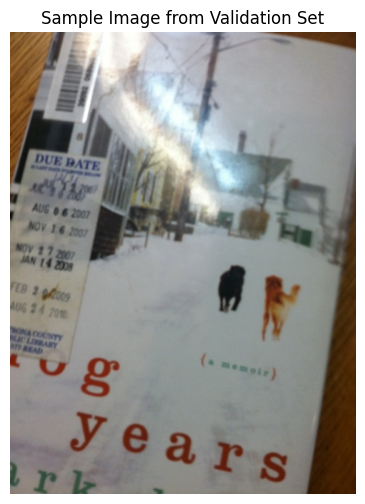

Before fine-tuning model generated caption: USER:  
ASSISTANT: The book is titled "A Year of Yes" and is a memoir. It is written by a woman who is a cancer survivor. The book is about her journey through cancer and the lessons she learned during that time. The book is also about her decision to live life to the fullest and the positive impact it had on her life.
Before fine-tuning model actual given caption for the sample: a white paper showing an image of black and brown dog


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,25.863900
200,15.101100
300,14.601500
400,14.379200
500,14.400700
600,14.381400
700,14.194400
800,14.267500
900,14.271700
1000,14.152700


After fine-tuning: USER:  
ASSISTANT: a book with a dog and a cat on the cover with a due date sticker on the bottom left corner of the book cover and a bar code sticker on the bottom right corner of the book cover with white lettering and black outlining on a white dog sitting in the snow with a house in the background and a green shed in the right side of the house with a green door and a green roof with a snow covered dog sitting in the snow and a green shed with a bar code sticker on the bottom right side of the book cover of the book a due date sticker on the bottom left side of the book and a bar code sticker on the bottom right side of the book cover with white lettering and black outlining on a white dog sitting in the snow with a house in the background and a green shed with a snow covered roof and a green door with a black dog sitting in the snow with a house in the background and a green shed with a snow covered roof and a green door with a bar code sticker on the bottom rig

In [ ]:
main()